# Imports

In [69]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn import tree
import sklearn.cluster as cluster
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
import plotly.express as px
import plotly.graph_objects as go
from scipy.optimize import minimize

np.random.seed(1234)

In [70]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
plt.rcParams.update({"axes.grid": True, "figure.figsize": (8, 4)})
import seaborn as sns

# sns.set()

# 15.1 Minimize an Arbitrary Function with Guess and Check

Define an arbitrary 4th order function with 2 local minima

In [71]:
def arbitrary(x):
    return (x**4 - 15 * x**3 + 80 * x**2 - 180 * x + 144) / 10.0


x = np.linspace(1, 6.75, 200)
px.line(y=arbitrary(x), x=x)

Notice that scipy minimize is affected by choice of initial guess
- Compare answer for x when guesing x0=6 vs. x0=1

In [72]:
minimize(arbitrary, x0=1)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.13827491294422317
        x: [ 2.393e+00]
      nit: 7
      jac: [-3.800e-07]
 hess_inv: [[ 7.475e-01]]
     nfev: 16
     njev: 8

In [73]:
minimize(arbitrary, x0=6)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.6914096788314851
        x: [ 5.326e+00]
      nit: 6
      jac: [ 9.157e-06]
 hess_inv: [[ 4.797e-01]]
     nfev: 14
     njev: 7

One approach - guess and check
- Terrible approach!
- Just try different values of x and see what happens

Another approach - use brute force search to try out a bunch of x values and choose the minimizer

In [74]:
def simple_minimize(fun, x):
    return x[np.argmin(fun(x))]


xs = np.linspace(1, 7, 20)
simple_minimize(arbitrary, xs)

5.421052631578947

In [75]:
fig = px.line(y=arbitrary(x), x=x)
fig.add_scatter(x=xs, y=arbitrary(xs), mode="markers")
fig.show()

This approach has 3 big problems:
- Range: what if actual minimizer is outside of the range you tried
- Resolution: the range may capture the minimizer, but the step size could be too coarse
- Inefficiency: expensive to compute all these f(x)

## 



# 15.2 Visualizing the Derivative

Minima of the functions occur at zero-crossings of the derivative

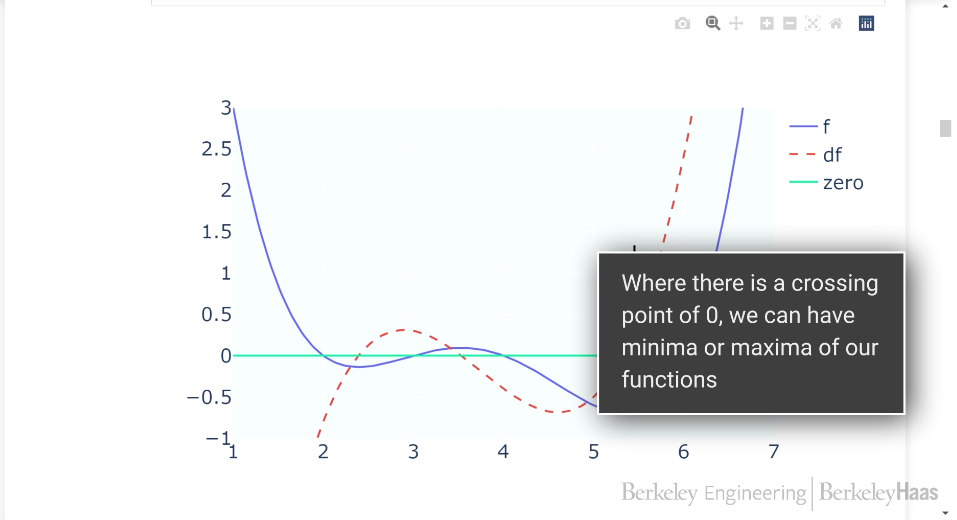

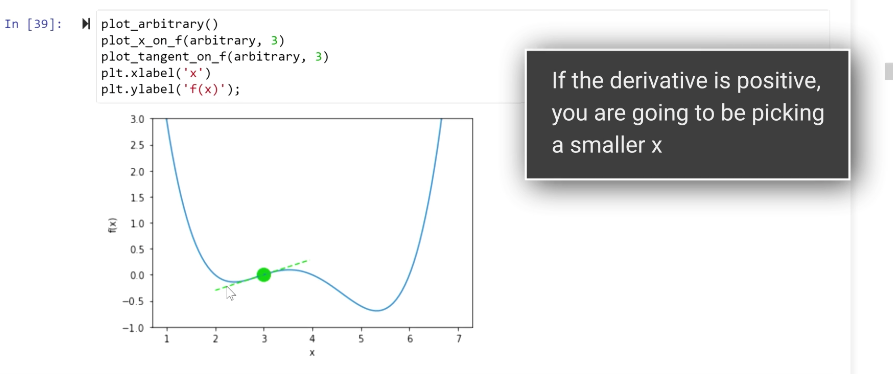

In [76]:
def derivative_arbitrary(x):
    return (4 * x**3 - 45 * x**2 + 160 * x - 180) / 10.0


def line(x):
    return 0 * x

In [77]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=arbitrary(x), mode="lines", name="f"))
fig.add_trace(
    go.Scatter(
        x=x, y=derivative_arbitrary(x), mode="lines", name="df", line={"dash": "dash"}
    )
)
fig.add_trace(go.Scatter(x=x, y=line(x), mode="lines", name="zero"))
fig.update_layout(autosize=False, width=1200, height=600)
fig.show()

# 15.3 Manually Descending the Gradient

In [78]:
guess = 5.3233
alpha = 0.25
print(
    "x = %.4f, f(x) = %.4f f'(x) = %.4f, next x = %.4f"
    % (
        guess,
        arbitrary(guess),
        derivative_arbitrary(guess),
        guess - alpha * derivative_arbitrary(guess),
    )
)

x = 5.3233, f(x) = -0.6914 f'(x) = -0.0064, next x = 5.3249


# 15.4 Gradient Descent in Code

Write the above procedure as a recurrence relation, which is

x(next) = x(current) - alpha*d/dx(fx)

where alpha is a configurable step parameter
- alpha is called the *learning rate*

Tradeoffs with alpha:

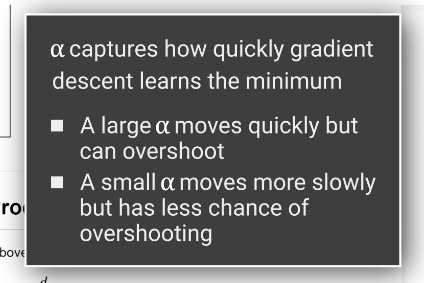

In [79]:
def gradient_descent(df, initial_guess, alpha, n):
    curr_guess = initial_guess
    all_guesses = []
    for _ in range(n):
        all_guesses.append(curr_guess)
        curr_guess -= alpha * df(curr_guess)
    return np.array(all_guesses)


gradient_descent(derivative_arbitrary, 4.0, 0.3, 20)

array([4.        , 4.12      , 4.26729664, 4.44272584, 4.64092624,
       4.8461837 , 5.03211854, 5.17201478, 5.25648449, 5.29791149,
       5.31542718, 5.3222606 , 5.32483298, 5.32578765, 5.32614004,
       5.32626985, 5.32631764, 5.32633523, 5.3263417 , 5.32634408])

# 15.5 Optimizing Linear Regression

In [80]:
tips = sns.load_dataset("tips")

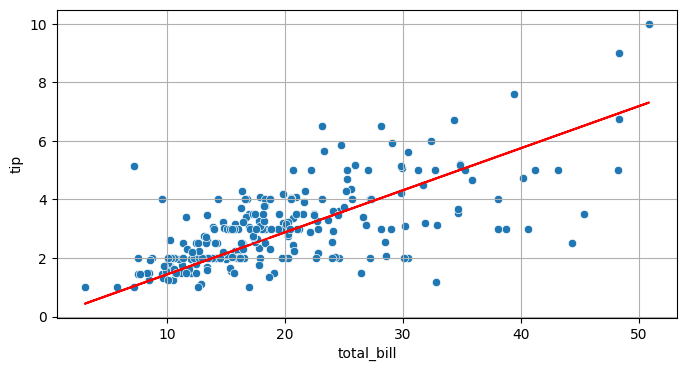

In [81]:
sns.scatterplot(x=tips["total_bill"], y=tips["tip"])
yhat = 0.1437 * tips["total_bill"]
plt.plot(tips["total_bill"], yhat, color="red")

Remember solving for the slope of the line y = m*x where x is total bill and y is tip, using linear regression
- m is chosen to minimize the mean squared error
- MSE is an arbitrary function

In [82]:
model = LinearRegression(fit_intercept=False).fit(tips[["total_bill"]], tips["tip"])
model.coef_

array([0.1437319])

Write a local version of MSE as a function of choice of theta (slope)

In [83]:
def mse_loss(theta1, x, y):
    return np.mean((y - theta1 * x) ** 2)


display([mse_loss(theta1=0.1, x=tips["total_bill"], y=tips["tip"])])
display([mse_loss(theta1=0.1437, x=tips["total_bill"], y=tips["tip"])])

[2.0777683729508194]

[1.1781165940051925]

To make the code easier to deal with, write a wrapper function mse_single_arg

In [84]:
mse_loss_single_arg = lambda theta1: mse_loss(
    theta1=theta1, x=tips["total_bill"], y=tips["tip"]
)
mse_loss_single_arg(theta1=0.1437)

1.1781165940051925

Now can use this function to visualize a brute force search for the loss-minimizing parameter

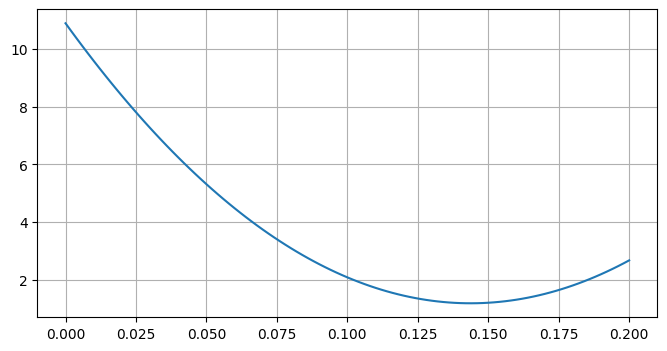

In [85]:
theta1_guesses = np.linspace(0, 0.2, 101)
mse_per_guess = [
    mse_loss_single_arg(theta1=theta1_guess) for theta1_guess in theta1_guesses
]
plt.plot(theta1_guesses, mse_per_guess)

Can also pass the MSE function to scipy optimize to have it find the best value to minimize the function (this is what sklearn does)

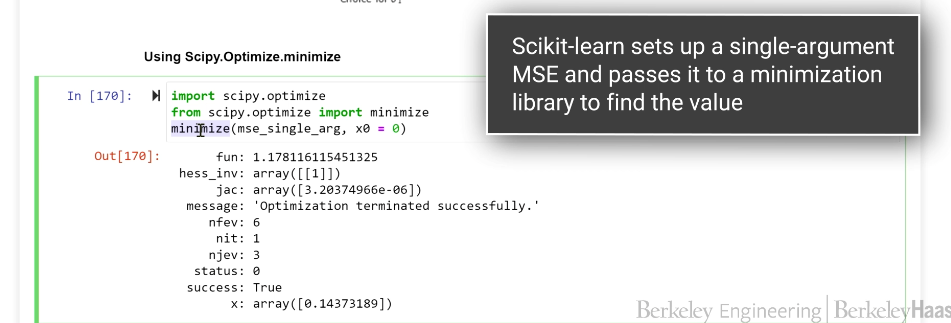

In [86]:
from scipy.optimize import minimize

In [87]:
minimize(mse_loss_single_arg, x0=0.0)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.178116115451325
        x: [ 1.437e-01]
      nit: 1
      jac: [ 3.204e-06]
 hess_inv: [[1]]
     nfev: 6
     njev: 3

Or, can now use the gradient descent approach
- Need to define the derivative of the MSE

In [88]:
def mse_loss_derivative(theta1, x, y):
    return np.mean(2 * (theta1 * x - y) * x)

In [89]:
mse_loss_derivative_single_arg = lambda guess: mse_loss_derivative(
    theta1=guess, x=tips["total_bill"], y=tips["tip"]
)
gradient_descent(
    df=mse_loss_derivative_single_arg, initial_guess=0.05, alpha=0.0001, n=100
)

array([0.05      , 0.05881852, 0.06680736, 0.0740446 , 0.08060095,
       0.08654045, 0.09192116, 0.09679563, 0.10121151, 0.10521192,
       0.10883597, 0.11211906, 0.11509327, 0.11778766, 0.12022855,
       0.1224398 , 0.12444301, 0.12625776, 0.12790176, 0.1293911 ,
       0.13074031, 0.13196259, 0.13306988, 0.13407298, 0.13498172,
       0.13580495, 0.13655074, 0.13722636, 0.13783841, 0.13839289,
       0.13889519, 0.13935024, 0.13976248, 0.14013593, 0.14047425,
       0.14078073, 0.14105839, 0.14130992, 0.14153778, 0.14174421,
       0.14193122, 0.14210063, 0.1422541 , 0.14239314, 0.14251909,
       0.14263319, 0.14273656, 0.1428302 , 0.14291504, 0.14299189,
       0.14306151, 0.14312458, 0.14318172, 0.14323348, 0.14328037,
       0.14332285, 0.14336134, 0.1433962 , 0.14342778, 0.14345639,
       0.14348231, 0.1435058 , 0.14352707, 0.14354634, 0.1435638 ,
       0.14357961, 0.14359394, 0.14360692, 0.14361868, 0.14362933,
       0.14363898, 0.14364772, 0.14365564, 0.14366281, 0.14366

New term alert!! Abstraction barrier - you don't need to know all the inner details to be conversant or able to work with a specific tool, like linear regression

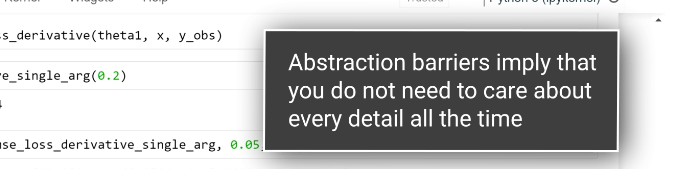

Writing down the results above in the context of minimizing loss

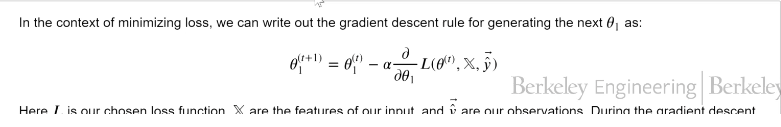

# 15.6 Convexity

Previously saw that gradient descent can get stuck in local minimums, not the global minimum that is desired
- But if a function is *convex*, then gradient descent will find the global minimum always

So what is a convex function?
- One that satisifies the following inequality

t * f(a) + (1 - t) * f(b) >= f(t * a - (1 - t) * b)

Notice that any function that satisifes homogeneity will be convex, where a homogeneous function satisfies  
f(alpha * x) = alpha * f(x)

Intuitive understanding is here

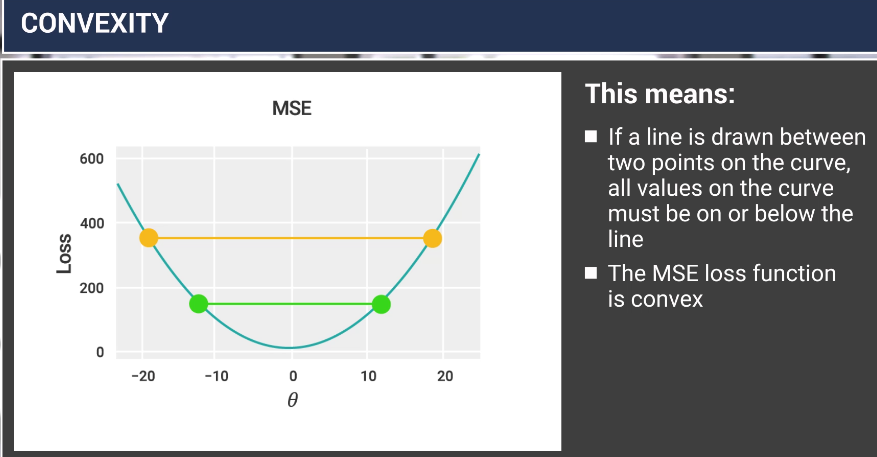

The good news about a convex function is that any discovered minimum is the global minimum
- Big implication is that the starting point of the search doesn't matter
- Because you will converge on not just any minimum, but the global minimum

What about non-convex functions?

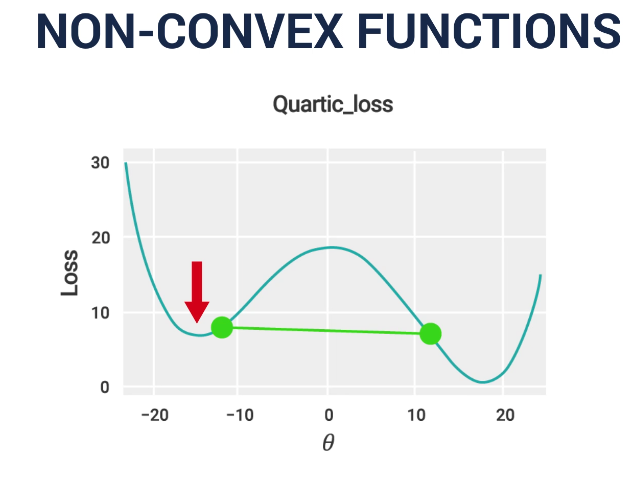

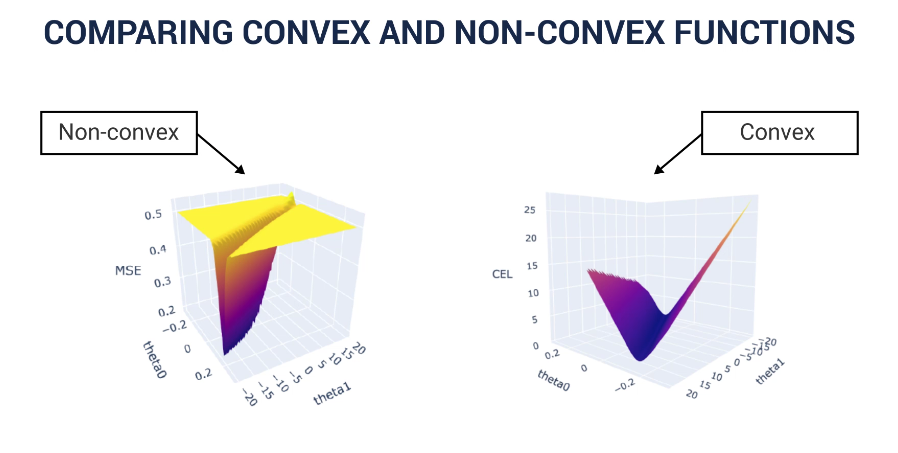

# 15.7 Optimizing 2D Linear Regression Using Non-Gradient Descent Techniques

Return to the tips data set

In [90]:
tips = sns.load_dataset("tips")
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [91]:
X = tips[["total_bill"]]
y = tips["tip"]
model = LinearRegression(fit_intercept=True).fit(X, y)
[model.intercept_, model.coef_]

[0.9202696135546731, array([0.10502452])]

To make things easier, replace the fit intercept with an explicit bias feature in the data

In [92]:
X = tips[["total_bill"]]
X["bias"] = 1.0
X = X.iloc[:, [1, 0]]
X.head()

,bias,total_bill
0,1.0,16.99
1,1.0,10.34
2,1.0,21.01
3,1.0,23.68
4,1.0,24.59


In [93]:
model = LinearRegression(fit_intercept=False).fit(X, y)
model.coef_

array([0.92026961, 0.10502452])

Can evaluate with matrix multiply with @ symbol as follows

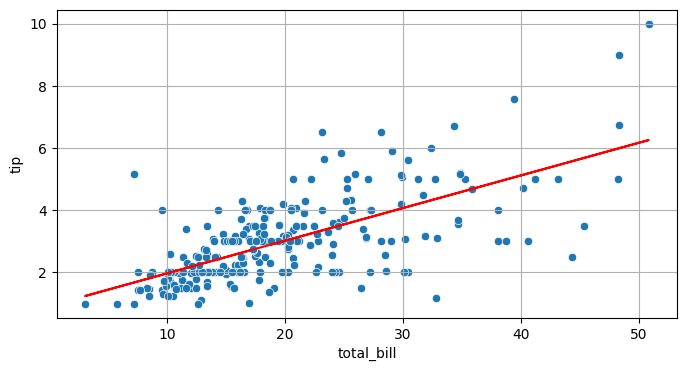

In [94]:
sns.scatterplot(x=tips["total_bill"], y=tips["tip"])
plt.plot(tips["total_bill"], X @ model.coef_, color="red")

In [95]:
def mse_loss(theta, x, y):
    return np.mean((y - x @ np.array(theta)) ** 2)


display(mse_loss(theta=[1.5, 0.05], x=X, y=y))
display(mse_loss(theta=model.coef_, x=X, y=y))

1.5340521752049179

1.036019442011377

As before, create a single-variable function

In [96]:
mse_loss_single_arg = lambda theta_guess: mse_loss(theta=theta_guess, x=X, y=y)
mse_loss_single_arg(model.coef_)

1.036019442011377

In [97]:
mse_loss_single_arg([0.92, 0.1])

1.0479490286885247

As before, can use scipy minimize

In [98]:
minimize(mse_loss_single_arg, x0=[0, 0]).x

array([0.92027035, 0.10502448])

In [99]:
model.coef_

array([0.92026961, 0.10502452])

# 15.8 2-D Gradient Descent

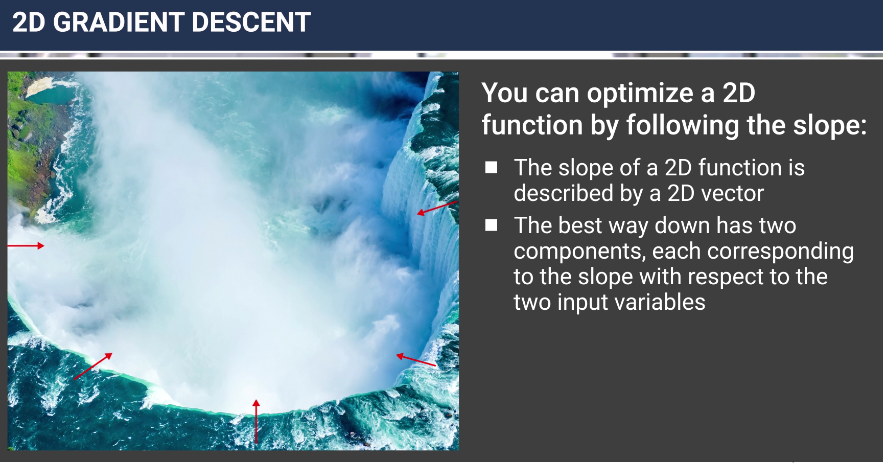

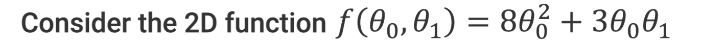

gradient = [16 * theta0 + 3 * theta1, 3 * theta0]

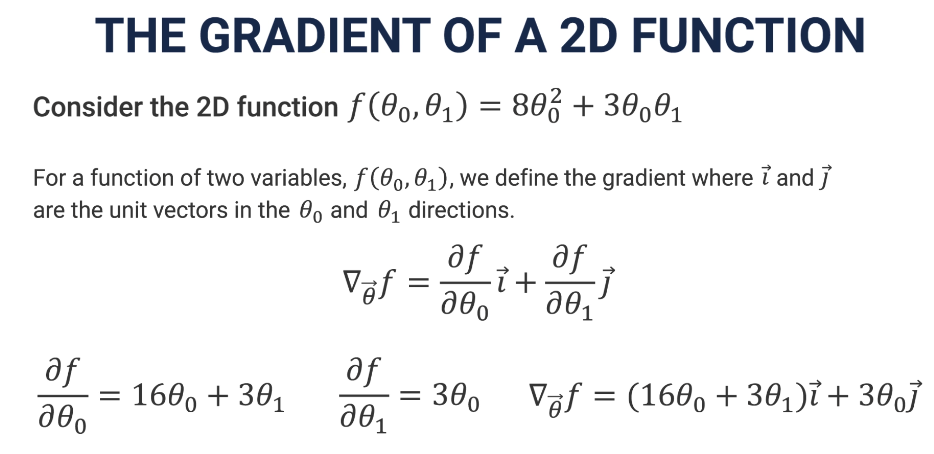

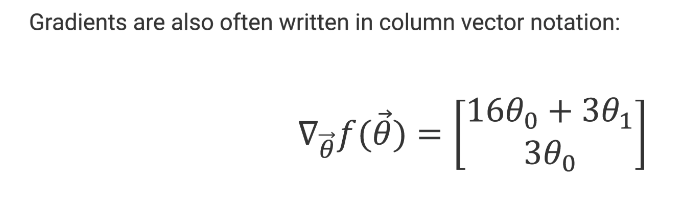

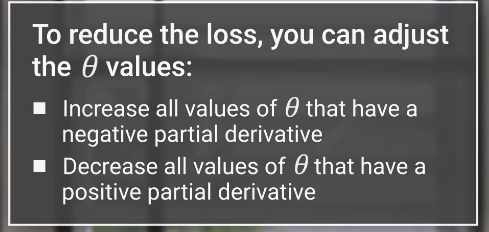

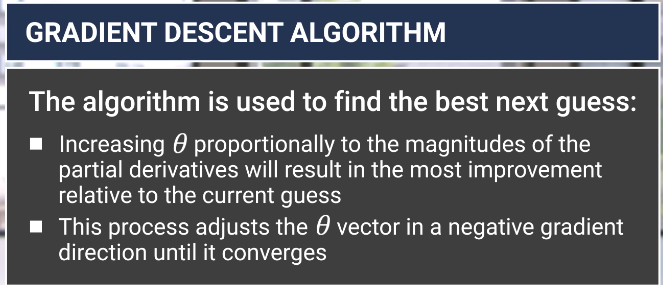

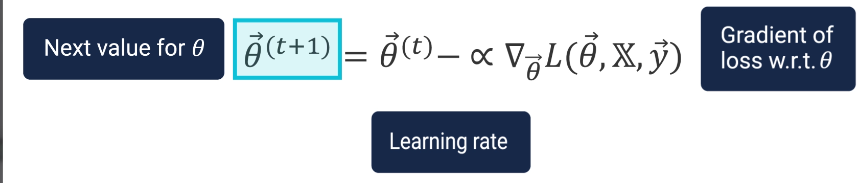

# 15.9 2D Gradient Descent for Linear Regression Part 1

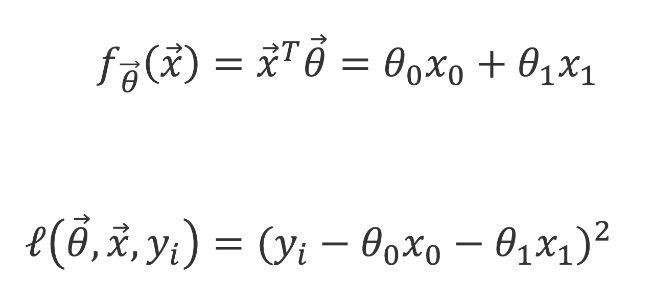

Pop quiz - define the gradient for this loss function for data point i?

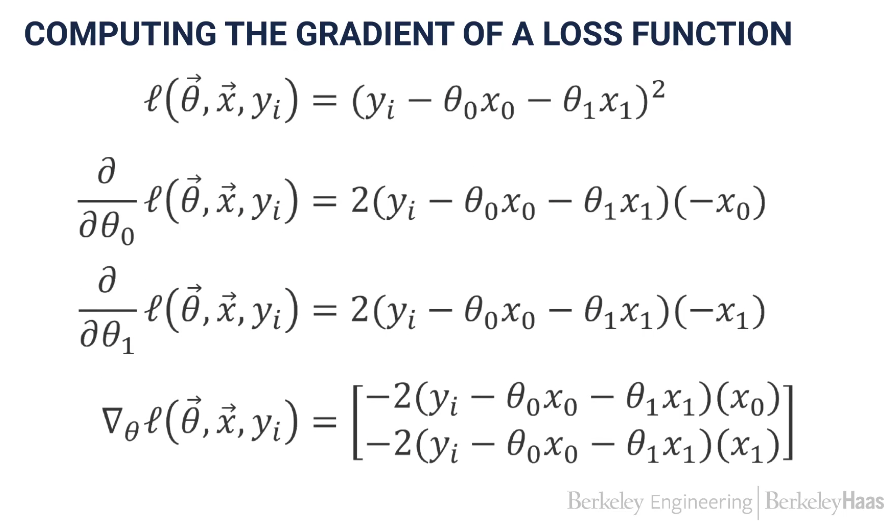

# 15.10 2D Gradient Descent for Linear Regression Part 2

In [131]:
def mse_loss_gradient(theta, X, y):
    x0 = X[:, 0]
    x1 = X[:, 1]
    return np.array(
        [
            np.mean(-2.0 * (y - theta[0] * x0 - theta[1] * x1) * x0),
            np.mean(-2.0 * (y - theta[0] * x0 - theta[1] * x1) * x1),
        ]
    )


mse_loss_gradient_single_arg = lambda theta: mse_loss_gradient(
    theta=np.array(theta), X=X.to_numpy(), y=y
)

In [246]:
mse_loss_gradient_single_arg([0.0, 0.0])

array([  -5.99655738, -135.22631803])

In [247]:
mse_loss_gradient_single_arg([0.9, 0.1])

array([-0.23936885, -5.52928992])

In [257]:
guesses = gradient_descent(df=mse_loss_gradient_single_arg, initial_guess=[0.0, 0.0], alpha=0.001, n=10000)

In [258]:
pd.DataFrame(guesses).tail(10)

,0,1
9990,0.888205,0.106374
9991,0.888205,0.106374
9992,0.888205,0.106374
9993,0.888205,0.106374
9994,0.888205,0.106374
9995,0.888205,0.106374
9996,0.888205,0.106374
9997,0.888205,0.106374
9998,0.888205,0.106374
9999,0.888205,0.106374


In [241]:
model = LinearRegression(fit_intercept=False).fit(X, y)
model.coef_

array([0.92026961, 0.10502452])